
# A. Business Understanding and Data Understanding


## A1. Business Understanding
### Background on Lending Club
LendingClub is an American peer-to-peer lending company, headquartered in San Francisco, California. It is the world's largest peer-to-peer lending platform.

LendingClub enables borrowers to create unsecured personal loans between \\$1,000 and \\$40,000. Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose, with the minimum investment of $25 per note. Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

### Business Goal
To identify loans to invest based on the loan portfolio performance. Potential loans are those demonstrates a high likelihood to be fully paid off. 

### Problem Solving Strategy
- Build a binary classifier: to predict which loans would be fully paid off
- From these loans, I will calculate the annual return to determine the paid off or charged off potential.

## A2. Data Understanding
The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#display all dataframe columns in df.head()
pd.options.display.max_columns = None
#display long string in datafame
pd.options.display.max_colwidth = 300

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from supabase import create_client, Client

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/.DS_Store
/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/.gitkeep
/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/lending_club_2007_2011_6_states.csv
/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/data_dictionary.csv


### A2.a. Data File

The data file **lending_club_2007_2011_6_states.csv** contains the loan and borrower information for loans initiated from 2007 to 2011 in six states, California, New York, Florida, Texas, New Jersey and Illinois.

The data dictionary file **data_dictionary.csv** contains descriptions of all the columns in the data file.

#### Data Dictionary

In [2]:
data_dict = pd.read_csv('/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/data_dictionary.csv')
data_dict

ColumnName  \
0                acc_now_delinq   
1                    addr_state   
2                    annual_inc   
3              application_type   
4      chargeoff_within_12_mths   
5       collection_recovery_fee   
6    collections_12_mths_ex_med   
7          debt_settlement_flag   
8     debt_settlement_flag_date   
9                   delinq_2yrs   
10                  delinq_amnt   
11          disbursement_method   
12                          dti   
13             earliest_cr_line   
14                   emp_length   
15                    emp_title   
16                  funded_amnt   
17              funded_amnt_inv   
18                        grade   
19                hardship_flag   
20               home_ownership   
21          initial_list_status   
22               inq_last_6mths   
23                  installment   
24                     int_rate   
25                      issue_d   
26           last_credit_pull_d   
27              last_pymnt_amnt   
28                 last_pymnt_d   
29                    loan_amnt   
30                  loan_status   
31       mths_since_last_delinq   
32  mths_since_last_major_derog   
33       mths_since_last_record   
34                 next_pymnt_d   
35                     open_acc   
36                    out_prncp   
37                out_prncp_inv   
38                  policy_code   
39                      pub_rec   
40         pub_rec_bankruptcies   
41                      purpose   
42                   pymnt_plan   
43                   recoveries   
44                    revol_bal   
45                   revol_util   
46                    sub_grade   
47                    tax_liens   
48                         term   
49                        title   
50                    total_acc   
51                  total_pymnt   
52              total_pymnt_inv   
53                total_rec_int   
54           total_rec_late_fee   
55              total_rec_prncp   
56          verification_status   
57                     zip_code   

                                                                                                                                                                                                 Description  
0                                                                                                                                            The number of accounts on which the borrower is now delinquent.  
1                                                                                                                                                 The state provided by the borrower in the loan application  
2                                                                                                                              The self-reported annual income provided by the borrower during registration.  
3                                                                                                       Indicates whether the loan is an individual application or a joint application with two co-borrowers  
4                                                                                                                                                                     Number of charge-offs within 12 months  
5                                                                                                                                                                             post charge off collection fee  
6                                                                                                                                           Number of collections in 12 months excluding medical collections  
7                                                                                                         Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.  
8                                                                                           

#### Loan Data

In [3]:
loan_df = pd.read_csv('/Users/miu/Data Science/DS Projects/lending_club_loan_portfolio/data/raw/lending_club_2007_2011_6_states.csv')
loan_df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  \
0   1       2400         2400           2400.0  36 months     15.96   
1   2      10000        10000          10000.0  36 months     13.49   
2   3       3000         3000           3000.0  36 months     18.64   
3   4       5600         5600           5600.0  60 months     21.28   
4   5       5375         5375           5350.0  60 months     12.69   

   installment grade sub_grade            emp_title emp_length home_ownership  \
0        84.33     C        C5                  NaN  10+ years           RENT   
1       339.31     C        C1  AIR RESOURCES BOARD  10+ years           RENT   
2       109.43     E        E1      MKC Accounting     9 years           RENT   
3       152.39     F        F2                  NaN    4 years            OWN   
4       121.45     B        B5            Starbucks   < 1 year           RENT   

   annual_inc verification_status issue_d  loan_status pymnt_plan  \
0       12252        Not Verified  Dec-11   Fully Paid          n   
1       49200     Source Verified  Dec-11   Fully Paid          n   
2       48000     Source Verified  Dec-11   Fully Paid          n   
3       40000     Source Verified  Dec-11  Charged Off          n   
4       15000            Verified  Dec-11  Charged Off          n   

          purpose                                 title zip_code addr_state  \
0  small_business                  real estate business    606xx         IL   
1           other                              personel    917xx         CA   
2             car                       Car Downpayment    900xx         CA   
3  small_business  Expand Business & Buy Debt Portfolio    958xx         CA   
4           other           Building my credit history.    774xx         TX   

     dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0   8.72            0           Nov-01               2   
1  20.00            0           Feb-96               1   
2   5.35            0           Jan-07               2   
3   5.55            0           Apr-04               2   
4  18.08            0           Sep-04               0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN         2        0   
1                    35.0                     NaN        10        0   
2                     NaN                     NaN         4        0   
3                     NaN                     NaN        11        0   
4                     NaN                     NaN         2        0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0       2956        98.5         10                   f          0   
1       5598        21.0         37                   f          0   
2       8221        87.5          4                   f          0   
3       5210        32.6         13                   f          0   
4       9279        36.5          3                   f          0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0              0   3005.666844          3005.67          2400.00   
1              0  12231.890000         12231.89         10000.00   
2              0   3939.135294          3939.14          3000.00   
3              0    647.500000           647.50           162.02   
4              0   1484.590000          1477.70           673.48   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         605.67                0.00        0.00                     0.00   
1        2214.92               16.97        0.00                     0.00   
2         939.14                0.00        0.00                     0.00   
3         294.94                0.00      190.54                     2.09   
4         533.42                0.00      277.69                     2.52   

  last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  \
0       Jun-14           649.91           NaN           

**Note**

Categorical features that potentially are influential: 
- term, grade, home_ownership, loan_status, purpose, addr_state

Numerical features that potentially are influential: 
- int_rate, annual_inc, pub_rec_bankruptcies

### A2.b. Check Basic DataFrame Information

In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           19908 non-null  int64  
 1   loan_amnt                    19908 non-null  int64  
 2   funded_amnt                  19908 non-null  int64  
 3   funded_amnt_inv              19908 non-null  float64
 4   term                         19908 non-null  object 
 5   int_rate                     19908 non-null  float64
 6   installment                  19908 non-null  float64
 7   grade                        19908 non-null  object 
 8   sub_grade                    19908 non-null  object 
 9   emp_title                    18723 non-null  object 
 10  emp_length                   19409 non-null  object 
 11  home_ownership               19908 non-null  object 
 12  annual_inc                   19908 non-null  int64  
 13  verification_sta

In [5]:
loan_df.isnull().sum()

id                                 0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                       1185
emp_length                       499
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
title                              5
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                        0
earliest_cr_line                   0
inq_last_6mths                     0
mths_since_last_delinq         12910
mths_since_last_record         18699
o

### A2.c Statistics of Numeric Columns

The descriptive statistics that summarize the central tendency, dispersion and shape of a dataset's distribution.

In [6]:
loan_df.describe()

id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  19908.000000  19908.000000  19908.000000     19908.000000   
mean    9954.500000  11353.846444  11065.763763     10500.929748   
std     5747.088915   7463.700492   7176.276661      7106.229650   
min        1.000000    500.000000    500.000000         0.000000   
25%     4977.750000   5750.000000   5600.000000      5000.000000   
50%     9954.500000  10000.000000  10000.000000      9000.000000   
75%    14931.250000  15000.000000  15000.000000     14500.000000   
max    19908.000000  35000.000000  35000.000000     35000.000000   

           int_rate   installment    annual_inc           dti   delinq_2yrs  \
count  19908.000000  19908.000000  1.990800e+04  19908.000000  19908.000000   
mean      12.089717    330.614254  7.107345e+04     13.008619      0.143962   
std        3.698287    210.557434  6.980565e+04      6.663658      0.489576   
min        5.420000     15.690000  4.000000e+03      0.000000      0.000000   
25%        9.450000    171.287500  4.200000e+04      7.840000      0.000000   
50%       11.860000    285.780000  6.000000e+04     13.075000      0.000000   
75%       14.610000    440.815000  8.500000e+04     18.200000      0.000000   
max       24.400000   1302.690000  6.000000e+06     29.990000     11.000000   

       inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
count    19908.000000             6998.000000             1209.000000   
mean         0.829466               35.841097               69.354839   
std          1.044978               21.599170               44.520279   
min          0.000000                0.000000                0.000000   
25%          0.000000               19.000000                0.000000   
50%          0.000000               34.000000               90.000000   
75%          1.000000               51.000000              104.000000   
max          8.000000              106.000000              129.000000   

           open_acc       pub_rec      revol_bal    revol_util     total_acc  \
count  19908.000000  19908.000000   19908.000000  19889.000000  19908.000000   
mean       9.278782      0.046715   13363.994826     49.424966     21.527627   
std        4.414903      0.217827   15943.303849     28.198395     11.269006   
min        2.000000      0.000000       0.000000      0.000000      2.000000   
25%        6.000000      0.000000    3770.500000     26.500000     13.000000   
50%        9.000000      0.000000    8876.500000     50.300000     20.000000   
75%       12.000000      0.000000   16952.250000     72.800000     28.000000   
max       44.000000      3.000000  148829.000000     99.900000     90.000000   

       out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  \
count    19908.0        19908.0  19908.000000     19908.000000   
mean         0.0            0.0  12286.852391     11690.155107   
std          0.0            0.0   9098.847567      8984.722396   
min          0.0            0.0      0.000000         0.000000   
25%          0.0            0.0   5670.592545      5239.857500   
50%          0.0            0.0  10042.735815      9427.845000   
75%          0.0            0.0  16681.688450     15983.440000   
max          0.0            0.0  58480.139920     58438.370000   

       total_rec_prncp  total_rec_int  total_rec_late_fee    recoveries  \
count     19908.000000   19908.000000        19908.000000  19908.000000   
mean       9913.519990    2277.120129            1.489973     94.722382   
std        7126.424699    2583.733214            7.964257    666.434583   
min           0.000000       0.000000            0.000000      0.000000   
25%        4800.000000     687.595000            0.000000      0.000000   
50%        8000.000000    1389.230000            0.000000      0.000000   
75%       14000.000000    2842.795000            0.000000      0.000000   
max       35000.020000   23480.140000          180.200000  29623.350000   

       collection_recovery_fee  last_pymnt

---

# B. EDA

Charged off = default = tendency of not being able to pay back

## B1. Loans distribution 

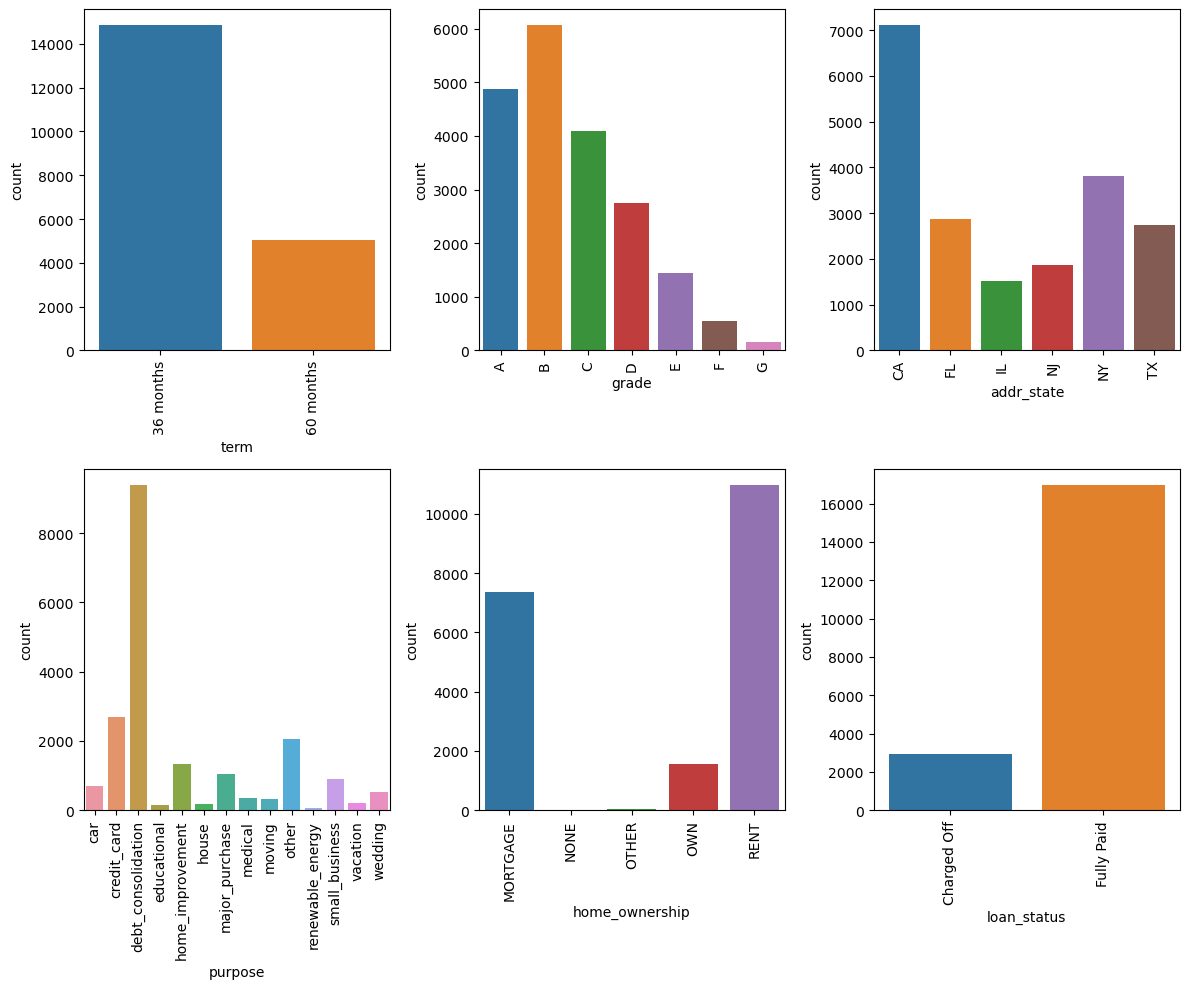

In [7]:
cat_feat = ['term', 'grade', 'addr_state', 'purpose', 'home_ownership', 'loan_status']

plt.figure(figsize=(12,10))

i=1
for col in cat_feat:
    plt.subplot(2,3,i)
    sns.countplot(x=loan_df[col], data=loan_df, order=sorted(loan_df[col].unique()))
    i +=1
    plt.xticks(rotation=90)
    plt.tight_layout()

In [8]:
loan_df['grade'].value_counts()/len(loan_df)

grade
B    0.304651
A    0.244876
C    0.205294
D    0.138035
E    0.072031
F    0.027125
G    0.007987
Name: count, dtype: float64

In [9]:
# percent of A+B+C loan grades
0.3046+0.2448+0.2052

0.7545999999999999

In [10]:
# percent of B loan grade
4875/len(loan_df)

0.24487643158529235

In [11]:
loan_df['addr_state'].value_counts()/len(loan_df)

addr_state
CA    0.356892
NY    0.191732
FL    0.144264
TX    0.137332
NJ    0.093179
IL    0.076602
Name: count, dtype: float64

**__ Findings __**
- Most loans are fully paid (~85%)
- Loans significantly come from:
    - state: CA, NY 
    - for debt_consolidation purpose
    - from renters and mortgage pay
- There are 7 grades loan A - G = high - low
    - The top 3 loan grades are: B, A, C with grade B has the highest amount
    
Term:
- There are two different loan terms, 36 months and 60 months.
- The number of 36-month loans is about ~ 3x more than 60-month loans in the dataset.
    
State:
- most loan are generated from CA (~6k), which is nearly double from NY
- loan from CA and NY made up half of the total loan from all 6 states

### Loan Issued Over Year

Explore the number of loans issued through LendingClub from 2007-2011. 

- Convert the **issue_d** column to a datetime type
- Count of loans in each year
- Create a new column **issue_year** with the year extracted from 'issue_d'

In [12]:
loan_df['issue_d'].value_counts().head()
# the format is month-year

issue_d
Dec-11    1159
Nov-11    1111
Oct-11    1069
Sep-11    1068
Aug-11     974
Name: count, dtype: int64

In [13]:
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], format="%b-%y")
loan_df['issue_year'] = loan_df['issue_d'].dt.year
loan_df[["issue_d", "issue_year"]].head()

issue_d  issue_year
0 2011-12-01        2011
1 2011-12-01        2011
2 2011-12-01        2011
3 2011-12-01        2011
4 2011-12-01        2011

In [14]:
loan_df.groupby(["issue_year", 'term']).agg({"term":"count"})

term
issue_year term           
2007       36 months    90
2008       36 months   780
2009       36 months  2363
2010       36 months  4399
           60 months  1462
2011       36 months  7220
           60 months  3594

In [15]:
loan_df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  \
0   1       2400         2400           2400.0  36 months     15.96   
1   2      10000        10000          10000.0  36 months     13.49   
2   3       3000         3000           3000.0  36 months     18.64   
3   4       5600         5600           5600.0  60 months     21.28   
4   5       5375         5375           5350.0  60 months     12.69   

   installment grade sub_grade            emp_title emp_length home_ownership  \
0        84.33     C        C5                  NaN  10+ years           RENT   
1       339.31     C        C1  AIR RESOURCES BOARD  10+ years           RENT   
2       109.43     E        E1      MKC Accounting     9 years           RENT   
3       152.39     F        F2                  NaN    4 years            OWN   
4       121.45     B        B5            Starbucks   < 1 year           RENT   

   annual_inc verification_status    issue_d  loan_status pymnt_plan  \
0       12252        Not Verified 2011-12-01   Fully Paid          n   
1       49200     Source Verified 2011-12-01   Fully Paid          n   
2       48000     Source Verified 2011-12-01   Fully Paid          n   
3       40000     Source Verified 2011-12-01  Charged Off          n   
4       15000            Verified 2011-12-01  Charged Off          n   

          purpose                                 title zip_code addr_state  \
0  small_business                  real estate business    606xx         IL   
1           other                              personel    917xx         CA   
2             car                       Car Downpayment    900xx         CA   
3  small_business  Expand Business & Buy Debt Portfolio    958xx         CA   
4           other           Building my credit history.    774xx         TX   

     dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0   8.72            0           Nov-01               2   
1  20.00            0           Feb-96               1   
2   5.35            0           Jan-07               2   
3   5.55            0           Apr-04               2   
4  18.08            0           Sep-04               0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN         2        0   
1                    35.0                     NaN        10        0   
2                     NaN                     NaN         4        0   
3                     NaN                     NaN        11        0   
4                     NaN                     NaN         2        0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0       2956        98.5         10                   f          0   
1       5598        21.0         37                   f          0   
2       8221        87.5          4                   f          0   
3       5210        32.6         13                   f          0   
4       9279        36.5          3                   f          0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0              0   3005.666844          3005.67          2400.00   
1              0  12231.890000         12231.89         10000.00   
2              0   3939.135294          3939.14          3000.00   
3              0    647.500000           647.50           162.02   
4              0   1484.590000          1477.70           673.48   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         605.67                0.00        0.00                     0.00   
1        2214.92               16.97        0.00                     0.00   
2         939.14                0.00        0.00                     0.00   
3         294.94                0.00      190.54                     2.09   
4         533.42                0.00      277.69                     2.52   

  last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  \
0       Jun-14           649.91       

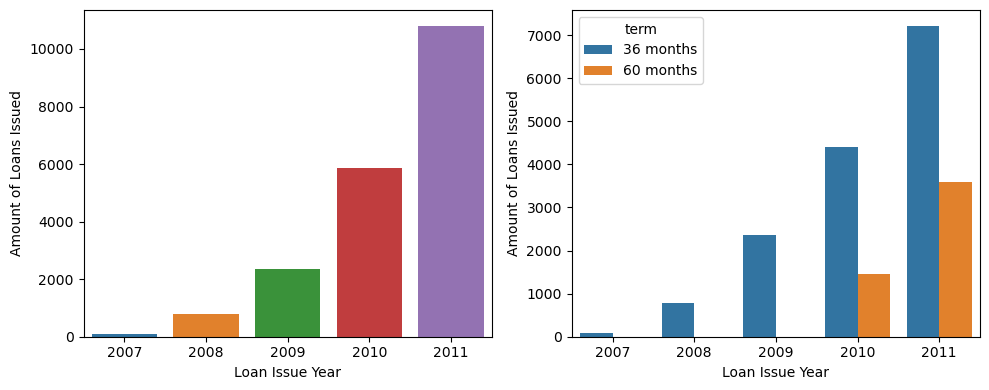

In [16]:
plt.subplots(1,2,figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=loan_df['issue_year'], data=loan_df)
plt.xlabel('Loan Issue Year')
plt.ylabel('Amount of Loans Issued');

# plt.subplot(1,3,2)
# count_year = loan_df['issue_year'].value_counts().reset_index()
# sns.lineplot(data = count_year, x='issue_year', y='count')
# plt.xlabel('Loan Issue Year')
# plt.ylabel('Amount of Loans Issued');

plt.subplot(1,2,2)
sns.countplot(x=loan_df['issue_year'], data=loan_df, hue='term')
plt.xlabel('Loan Issue Year')
plt.ylabel('Amount of Loans Issued');

plt.tight_layout()

**__ Findings __**
- the amount of issued loans seems to grow exponentially over the range of 2007 - 2011. 
- loans in 2008 is 8x more than in 2007
- amount of loans increases 2x/year from 2009 to 2011
- 60-month loan term is introduced in 2010

## B2. Interest Rate distribution

Text(0.5, 0, 'Interest Rate (%)')

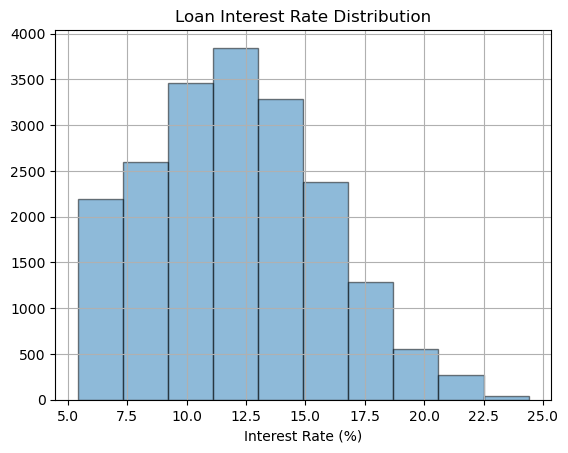

In [17]:
loan_df['int_rate'].hist(edgecolor='black', alpha=0.5)
plt.title('Loan Interest Rate Distribution')
plt.xlabel('Interest Rate (%)')

Interest rate is in the range of 5% to 25%. Majority of loans have interest rate between 5-17%.


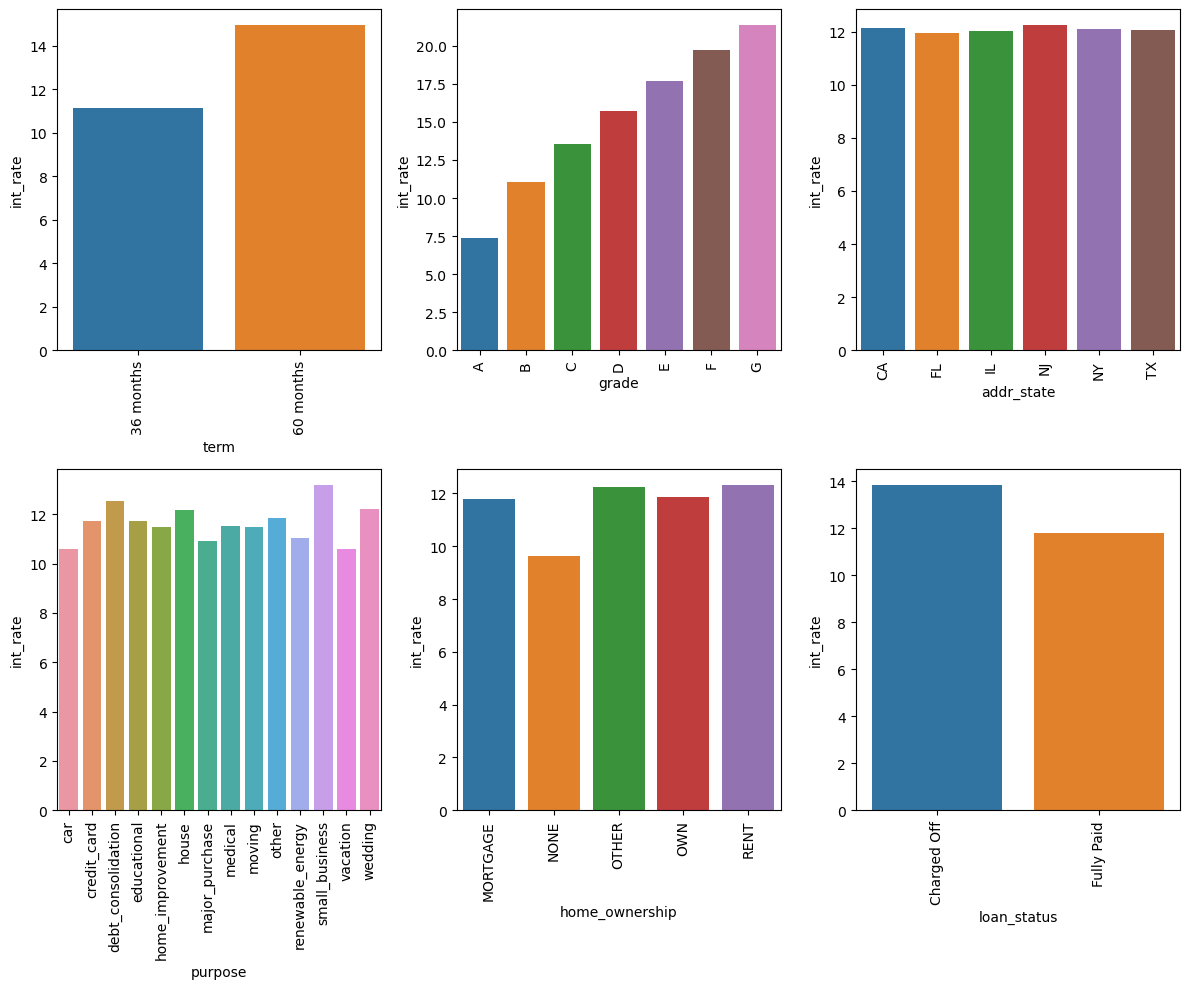

In [18]:
plt.figure(figsize=(12,10))

i=1
for col in cat_feat:
    plt.subplot(2,3,i)
    x = loan_df.groupby(col)['int_rate'].mean().index
    y = loan_df.groupby(col)['int_rate'].mean()
    sns.barplot(x=x, y=y)
    i +=1
    plt.xticks(rotation=90)
    plt.tight_layout()

**__ Findings __**
- 36-month term has a lower average interest rate than 60-month term.
- Paid off loans has lower interest rate.  
- The average interest rate is linear correlated with the loan Grade, descendingly:
    - as loan grade goes lower (A -> G), the interest rate increased
- Grade B loan has the average interest rate of 11.03, which is close to the overall interest rate mean 12.09
- The interest rate are not influenced by state, purpose, nor home ownership status

### Interest Rate Change in each State over Year

In [19]:
loan_df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  \
0   1       2400         2400           2400.0  36 months     15.96   
1   2      10000        10000          10000.0  36 months     13.49   
2   3       3000         3000           3000.0  36 months     18.64   
3   4       5600         5600           5600.0  60 months     21.28   
4   5       5375         5375           5350.0  60 months     12.69   

   installment grade sub_grade            emp_title emp_length home_ownership  \
0        84.33     C        C5                  NaN  10+ years           RENT   
1       339.31     C        C1  AIR RESOURCES BOARD  10+ years           RENT   
2       109.43     E        E1      MKC Accounting     9 years           RENT   
3       152.39     F        F2                  NaN    4 years            OWN   
4       121.45     B        B5            Starbucks   < 1 year           RENT   

   annual_inc verification_status    issue_d  loan_status pymnt_plan  \
0       12252        Not Verified 2011-12-01   Fully Paid          n   
1       49200     Source Verified 2011-12-01   Fully Paid          n   
2       48000     Source Verified 2011-12-01   Fully Paid          n   
3       40000     Source Verified 2011-12-01  Charged Off          n   
4       15000            Verified 2011-12-01  Charged Off          n   

          purpose                                 title zip_code addr_state  \
0  small_business                  real estate business    606xx         IL   
1           other                              personel    917xx         CA   
2             car                       Car Downpayment    900xx         CA   
3  small_business  Expand Business & Buy Debt Portfolio    958xx         CA   
4           other           Building my credit history.    774xx         TX   

     dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0   8.72            0           Nov-01               2   
1  20.00            0           Feb-96               1   
2   5.35            0           Jan-07               2   
3   5.55            0           Apr-04               2   
4  18.08            0           Sep-04               0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN         2        0   
1                    35.0                     NaN        10        0   
2                     NaN                     NaN         4        0   
3                     NaN                     NaN        11        0   
4                     NaN                     NaN         2        0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0       2956        98.5         10                   f          0   
1       5598        21.0         37                   f          0   
2       8221        87.5          4                   f          0   
3       5210        32.6         13                   f          0   
4       9279        36.5          3                   f          0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0              0   3005.666844          3005.67          2400.00   
1              0  12231.890000         12231.89         10000.00   
2              0   3939.135294          3939.14          3000.00   
3              0    647.500000           647.50           162.02   
4              0   1484.590000          1477.70           673.48   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         605.67                0.00        0.00                     0.00   
1        2214.92               16.97        0.00                     0.00   
2         939.14                0.00        0.00                     0.00   
3         294.94                0.00      190.54                     2.09   
4         533.42                0.00      277.69                     2.52   

  last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  \
0       Jun-14           649.91       

In [20]:
year_state = pd.pivot_table(loan_df, index=["issue_year"],
                             columns=["addr_state"], values="int_rate",
                             aggfunc="median")

Text(0, 0.5, 'Median Interest Rate')

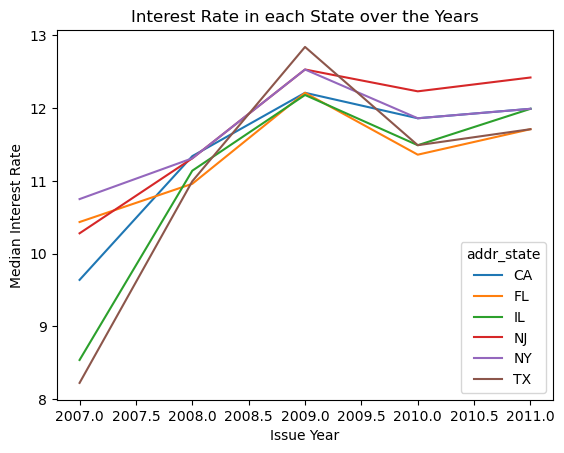

In [21]:
ax = loan_df.pivot_table(index=["issue_year"],
                             columns=["addr_state"], values="int_rate",
                             aggfunc=np.median).plot.line()

ax.set_title('Interest Rate in each State over the Years')
ax.set_xlabel('Issue Year')
ax.set_ylabel('Median Interest Rate')

# plt.figure(figsize=(6,4))

# sns.lineplot(year_state)
# plt.title('Interest Rate in each State over the Years')
# plt.xlabel('Issue Year')
# plt.ylabel('Median Interest Rate')

# plt.tight_layout()

In [22]:
year_state.diff()

addr_state    CA     FL    IL    NJ    NY     TX
issue_year                                      
2007         NaN    NaN   NaN   NaN   NaN    NaN
2008        1.70  0.525  2.60  1.03  0.56  2.770
2009        0.87  1.250  1.04  1.22  1.22  1.845
2010       -0.35 -0.850 -0.69 -0.30 -0.67 -1.350
2011        0.13  0.350  0.50  0.19  0.13  0.220

**__ Findings __**

The interest rate follows a same trend across the 6 states:
- The interest rate increased from 2007 and reached the peak at 2009
- Declined in 2010, and slightly increased in 2011

Some of the steepest increase took place from in 2008 and 2009:
- TX: 2.8% in 2008 and 1.8% in 2009
- IL increased 2.6% in 2008 
- CA: 1.7% in 2008

## B3. Borrowers Annual Income distribution

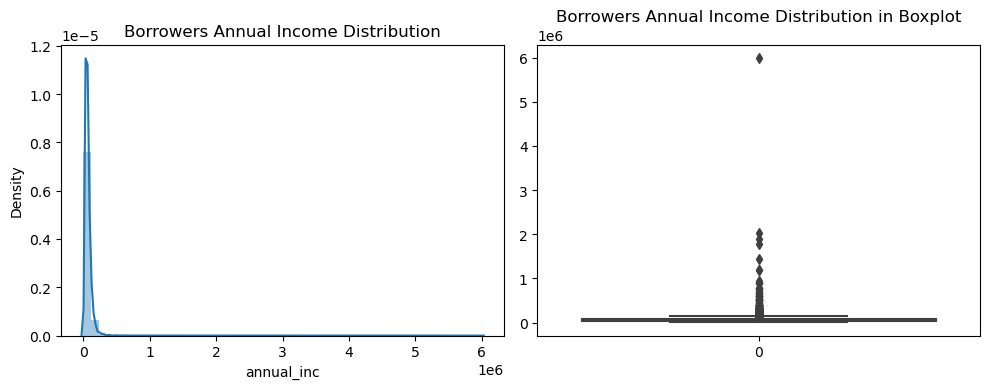

In [23]:
plt.subplots(1,2,figsize=(10,4))

plt.subplot(1,2,1)
sns.distplot(loan_df['annual_inc'])
plt.title('Borrowers Annual Income Distribution');

plt.subplot(1,2,2)
sns.boxplot(loan_df['annual_inc'])
plt.title('Borrowers Annual Income Distribution in Boxplot');

plt.tight_layout()

array([[<Axes: title={'center': 'annual_inc'}>]], dtype=object)

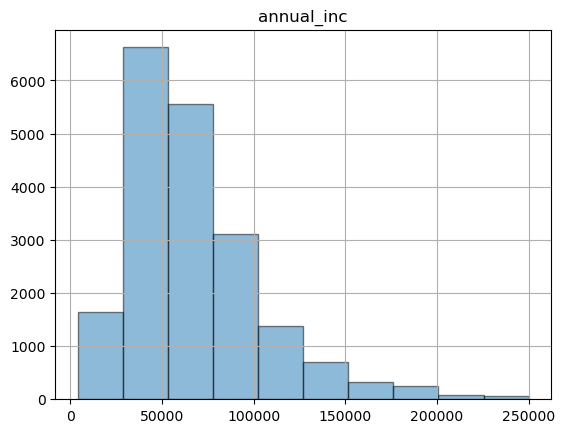

In [24]:
# Since the annual income is very skewed to the right, I need to narrow down range for visualization
loan_df[loan_df['annual_inc'] < 250000].hist(column='annual_inc', edgecolor='black', alpha=0.5)

**__ Findings __**
- The annual income follows a right-skewed distribtuion with a very long right tail.
- There are notable outliers on the right side, with the max annual income of 6M dollars
- The distribution mainly concentrates under 250k dollars

### B3.a. Borrower Annual Income by State

In [25]:
loan_df.groupby('addr_state').agg({'annual_inc':'median'})

annual_inc
addr_state            
CA             60000.0
FL             53000.0
IL             59500.0
NJ             63000.0
NY             60000.0
TX             60000.0

Text(0, 0.5, 'Median Income')

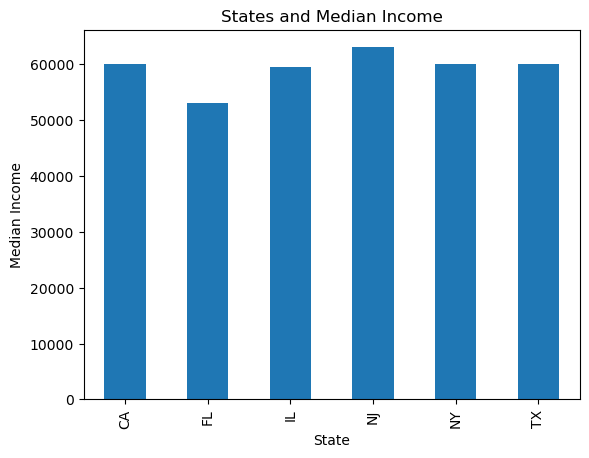

In [26]:
ax = loan_df.groupby('addr_state').agg({'annual_inc':'median'}).plot.bar(legend = False)
ax.set_title('States and Median Income')
ax.set_xlabel('State')
ax.set_ylabel('Median Income')

**__ Findings __**
- The median income across 6 states is similar, around 60k dollars
- Florida median income is the lowest, at 53k dollars

### B3.b. Annual Income and Interest Rate

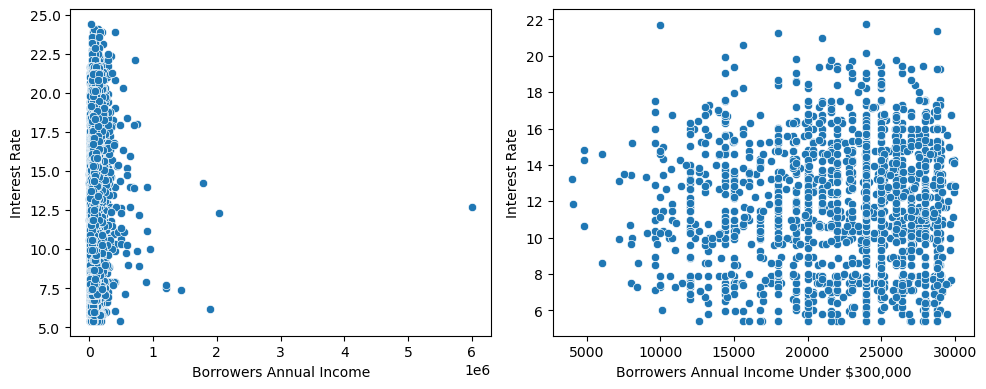

In [27]:
plt.subplots(1,2,figsize=(10,4))

# Full range of annual income
plt.subplot(121)
sns.scatterplot(data=loan_df, x='annual_inc', y='int_rate')
plt.xlabel('Borrowers Annual Income')
plt.ylabel('Interest Rate');

# Annual income < $300,000
plt.subplot(122)
sns.scatterplot(data=loan_df[loan_df['annual_inc']<30000], x='annual_inc', y='int_rate')
plt.xlabel('Borrowers Annual Income Under $300,000')
plt.ylabel('Interest Rate')

plt.tight_layout()

**__ Findings __**
- It looks like there is no correlation between the borrowers' annual income and the interest rate

## B4. Loan Status

The loans in the dataset were issued before 2011 and the longest loan term is 5 years. So all the loans are either paid off or charged off (aka a loss) as of now, 2023

Explore loan status and find out:
- The number of paid off loans and charged off loans
- Paid off rate of the whole dataset.

$PaidOffRate = \frac{FullyPaid}{Fully Paid+Charged Off}$


In [28]:
loan_df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  \
0   1       2400         2400           2400.0  36 months     15.96   
1   2      10000        10000          10000.0  36 months     13.49   
2   3       3000         3000           3000.0  36 months     18.64   
3   4       5600         5600           5600.0  60 months     21.28   
4   5       5375         5375           5350.0  60 months     12.69   

   installment grade sub_grade            emp_title emp_length home_ownership  \
0        84.33     C        C5                  NaN  10+ years           RENT   
1       339.31     C        C1  AIR RESOURCES BOARD  10+ years           RENT   
2       109.43     E        E1      MKC Accounting     9 years           RENT   
3       152.39     F        F2                  NaN    4 years            OWN   
4       121.45     B        B5            Starbucks   < 1 year           RENT   

   annual_inc verification_status    issue_d  loan_status pymnt_plan  \
0       12252        Not Verified 2011-12-01   Fully Paid          n   
1       49200     Source Verified 2011-12-01   Fully Paid          n   
2       48000     Source Verified 2011-12-01   Fully Paid          n   
3       40000     Source Verified 2011-12-01  Charged Off          n   
4       15000            Verified 2011-12-01  Charged Off          n   

          purpose                                 title zip_code addr_state  \
0  small_business                  real estate business    606xx         IL   
1           other                              personel    917xx         CA   
2             car                       Car Downpayment    900xx         CA   
3  small_business  Expand Business & Buy Debt Portfolio    958xx         CA   
4           other           Building my credit history.    774xx         TX   

     dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0   8.72            0           Nov-01               2   
1  20.00            0           Feb-96               1   
2   5.35            0           Jan-07               2   
3   5.55            0           Apr-04               2   
4  18.08            0           Sep-04               0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN         2        0   
1                    35.0                     NaN        10        0   
2                     NaN                     NaN         4        0   
3                     NaN                     NaN        11        0   
4                     NaN                     NaN         2        0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0       2956        98.5         10                   f          0   
1       5598        21.0         37                   f          0   
2       8221        87.5          4                   f          0   
3       5210        32.6         13                   f          0   
4       9279        36.5          3                   f          0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0              0   3005.666844          3005.67          2400.00   
1              0  12231.890000         12231.89         10000.00   
2              0   3939.135294          3939.14          3000.00   
3              0    647.500000           647.50           162.02   
4              0   1484.590000          1477.70           673.48   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         605.67                0.00        0.00                     0.00   
1        2214.92               16.97        0.00                     0.00   
2         939.14                0.00        0.00                     0.00   
3         294.94                0.00      190.54                     2.09   
4         533.42                0.00      277.69                     2.52   

  last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  \
0       Jun-14           649.91       

In [29]:
# Overall Paid off rate and Charged Off rate
loan_df['loan_status'].value_counts()/loan_df.shape[0]

loan_status
Fully Paid     0.85217
Charged Off    0.14783
Name: count, dtype: float64

In [30]:
labels = loan_df['loan_status'].value_counts().index

fig = go.Figure(data=[go.Pie(labels=labels, values=loan_df['loan_status'].value_counts())])
fig.show()

#sns.countplot(x="loan_status", data=loan_df)

### Loan Term and Loan Status

In [65]:
pt_term = pd.pivot_table(loan_df, index=["term"],
                         columns=["loan_status"], values="int_rate",
                         aggfunc="count")
pt_term['payoff rate'] = round((pt_term["Fully Paid"] / (pt_term["Fully Paid"] + pt_term["Charged Off"])),2)
pt_term['default rate'] = 1- pt_term['payoff rate']
pt_term

loan_status  Charged Off  Fully Paid  payoff rate  default rate
term                                                           
36 months           1728       13124         0.88          0.12
60 months           1215        3841         0.76          0.24

### Loan Grade and Loan Status

In [67]:
pt_grade = pd.pivot_table(loan_df, index=["grade"],
                         columns=["loan_status"], values="int_rate",
                         aggfunc="count")
pt_grade['payoff rate'] = round((pt_grade["Fully Paid"] / (pt_grade["Fully Paid"] + pt_grade["Charged Off"])),2)
pt_grade['default rate'] = 1- pt_grade['payoff rate']
pt_grade

loan_status  Charged Off  Fully Paid  payoff rate  default rate
grade                                                          
A                    304        4571         0.94          0.06
B                    779        5286         0.87          0.13
C                    672        3415         0.84          0.16
D                    579        2169         0.79          0.21
E                    378        1056         0.74          0.26
F                    174         366         0.68          0.32
G                     57         102         0.64          0.36

**__ Findings __**

Term:
- The overall payoff rate is 85.2%, in which 77% is from 3-year term
- The payoff rate of 3-year term is higher than 5-year term

Grade:
- Recall: interest rate increase across A - G
- payoffRate decreases across loan grade A - G
- Higher grades (A-C) have lower interest rate and higer payoff rate

## B5. EDA Conclusions

**Impactful features**
Features that seem to have impact on whether a loan will be fully paid are interest rate, loan term, and loan grade. 
- The loan is more likely to be fully paid if the interest rate is low, has a high grade, and in a 3-year term  
- There is no correlation between interest rate and the borrowers' annual income

Although the interest rate varied by states, the same trend took place at across 6 states in which it hiked up most in 2009. States interest rate in 2011 in descendig order is: NJ, NY-CA-IL (tie), TX-FL (tie)

---

# C. Data Preparation, Modeling and Model Evaluation

Questions:
1. What features should be selected for the classification model?
2. What data pre-processing techniques are for categorical features and what are for continuous features?
3. How does different class_weight affect a classification model?
4. What is the difference of precision and recall?


## C1. Data Processing


The dataset has loans initiated from 2007 to 2011. By 2023, all loans had been either fully paid or charged off. I will create a `repaid` column in loan_df by encoding loan status and map:
- Charged Off to 0
- Fully Paid to 1.

The `repaid` column is the target column for the predictive model

In [33]:
mapping_dict = {'Charged Off':0, 'Fully Paid':1}
loan_df['repaid'] = loan_df.loan_status.map(mapping_dict)
loan_df.repaid.value_counts()

repaid
1    16965
0     2943
Name: count, dtype: int64

In [34]:
# paid off rate:
print("Paid-off rate is: ", round(loan_df["repaid"].mean()*100,2))
print("Charged off rate is: ", round((1-loan_df["repaid"].mean())*100,2))

Paid-off rate is:  85.22
Charged off rate is:  14.78


**Loan Term in Year**

Create a new column `loan_term_year` in loan_df to encode:
- '36 months': 3 (int)
- '60 months': 5 (int)

In [35]:
# Create a column 'loan_term_year'
loan_df['loan_term_year'] = loan_df['term'].apply(lambda x: 3 if x == "36 months" else 5)

### C1.a. Missing Values

- Fill missing values in `revol_util` with the mean value of the column in loan_df.
- Fill missing values in `pub_rec_bankruptcies` with 0 (which is the mode of the column) in loan_df.

In [36]:
loan_df[["revol_util", "pub_rec_bankruptcies"]].isnull().sum()/len(loan_df)

revol_util              0.000954
pub_rec_bankruptcies    0.015722
dtype: float64

In [37]:
loan_df['revol_util'] = loan_df['revol_util'].fillna(loan_df['revol_util'].mean())
loan_df['pub_rec_bankruptcies'] = loan_df['pub_rec_bankruptcies'].fillna(0)

<Axes: >

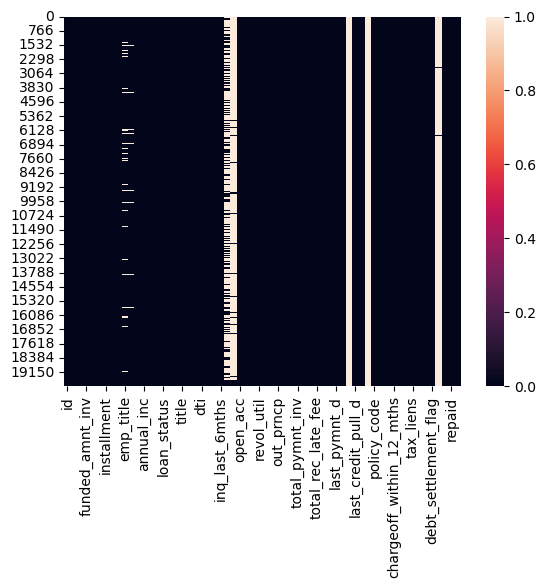

In [38]:
sns.heatmap(loan_df.isnull())

In [39]:
loan_df[["revol_util", "pub_rec_bankruptcies"]].isnull().sum()

revol_util              0
pub_rec_bankruptcies    0
dtype: int64

### C1.b. Categorical Features

Encode them with label encoding and create following new columns in loan_df.

- purpose_code
- grade_code
- home_ownership_code
- addr_state_code

Repaid rate of loans with different purpose:
- Loans for small business has the lowest repaid rate 
- Loans for cars and weddings have the highest repaid rate. 
- Most loans in the dataset are for debt consolidation.

Repaid rate in each states:
- CA has the most loans, while the repaid is only at the second to last repaid rae
- TX has the highest repaid rate

In [40]:
# relationship between purpose and repaid rate
# 'issue_d' col is used to count the number of loans for each purpose
loan_df.groupby('purpose').agg(repaid_rate = ('repaid', 'mean'),
                               num_loans = ('issue_d', 'count')).sort_values(by='repaid_rate')

repaid_rate  num_loans
purpose                                   
small_business         0.728177        905
educational            0.801242        161
house                  0.823864        176
moving                 0.829653        317
other                  0.843689       2060
debt_consolidation     0.845670       9389
medical                0.854286        350
vacation               0.859296        199
renewable_energy       0.862745         51
home_improvement       0.875188       1330
credit_card            0.885757       2696
major_purchase         0.887405       1048
car                    0.892285        687
wedding                0.894249        539

In [41]:
#relationship between state and repaid rate
loan_df.groupby('addr_state').agg(repaid_rate = ('repaid', 'mean'),
                                num_loans = ('issue_d', 'count')).sort_values(by='repaid_rate')

repaid_rate  num_loans
addr_state                        
FL             0.822772       2872
CA             0.840816       7105
NJ             0.847978       1855
NY             0.868745       3817
IL             0.870164       1525
TX             0.882224       2734

In [42]:
loan_df.groupby('grade').agg(repaid_rate = ('repaid', 'mean'),
                                 num_loans = ('issue_d', 'count')).sort_values(by='repaid_rate')

repaid_rate  num_loans
grade                        
G         0.641509        159
F         0.677778        540
E         0.736402       1434
D         0.789301       2748
C         0.835576       4087
B         0.871558       6065
A         0.937641       4875

In [43]:
loan_df.groupby('home_ownership').agg(repaid_rate = ('repaid', 'mean'),
                                 num_loans = ('issue_d', 'count')).sort_values(by='repaid_rate')

repaid_rate  num_loans
home_ownership                        
OTHER              0.818182         44
OWN                0.841527       1546
RENT               0.847620      10966
MORTGAGE           0.861379       7351
NONE               1.000000          1

In [44]:
to_code_feat = loan_df[['grade', 'addr_state', 'purpose', 'home_ownership']]

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_feat:
    loan_df[col + "_code"] = le.fit_transform(loan_df[col])

In [46]:
loan_df.head()

id  loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  \
0   1       2400         2400           2400.0  36 months     15.96   
1   2      10000        10000          10000.0  36 months     13.49   
2   3       3000         3000           3000.0  36 months     18.64   
3   4       5600         5600           5600.0  60 months     21.28   
4   5       5375         5375           5350.0  60 months     12.69   

   installment grade sub_grade            emp_title emp_length home_ownership  \
0        84.33     C        C5                  NaN  10+ years           RENT   
1       339.31     C        C1  AIR RESOURCES BOARD  10+ years           RENT   
2       109.43     E        E1      MKC Accounting     9 years           RENT   
3       152.39     F        F2                  NaN    4 years            OWN   
4       121.45     B        B5            Starbucks   < 1 year           RENT   

   annual_inc verification_status    issue_d  loan_status pymnt_plan  \
0       12252        Not Verified 2011-12-01   Fully Paid          n   
1       49200     Source Verified 2011-12-01   Fully Paid          n   
2       48000     Source Verified 2011-12-01   Fully Paid          n   
3       40000     Source Verified 2011-12-01  Charged Off          n   
4       15000            Verified 2011-12-01  Charged Off          n   

          purpose                                 title zip_code addr_state  \
0  small_business                  real estate business    606xx         IL   
1           other                              personel    917xx         CA   
2             car                       Car Downpayment    900xx         CA   
3  small_business  Expand Business & Buy Debt Portfolio    958xx         CA   
4           other           Building my credit history.    774xx         TX   

     dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0   8.72            0           Nov-01               2   
1  20.00            0           Feb-96               1   
2   5.35            0           Jan-07               2   
3   5.55            0           Apr-04               2   
4  18.08            0           Sep-04               0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     NaN                     NaN         2        0   
1                    35.0                     NaN        10        0   
2                     NaN                     NaN         4        0   
3                     NaN                     NaN        11        0   
4                     NaN                     NaN         2        0   

   revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0       2956        98.5         10                   f          0   
1       5598        21.0         37                   f          0   
2       8221        87.5          4                   f          0   
3       5210        32.6         13                   f          0   
4       9279        36.5          3                   f          0   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0              0   3005.666844          3005.67          2400.00   
1              0  12231.890000         12231.89         10000.00   
2              0   3939.135294          3939.14          3000.00   
3              0    647.500000           647.50           162.02   
4              0   1484.590000          1477.70           673.48   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         605.67                0.00        0.00                     0.00   
1        2214.92               16.97        0.00                     0.00   
2         939.14                0.00        0.00                     0.00   
3         294.94                0.00      190.54                     2.09   
4         533.42                0.00      277.69                     2.52   

  last_pymnt_d  last_pymnt_amnt  next_pymnt_d last_credit_pull_d  \
0       Jun-14           649.91       

# D. Modeling and Model Evaluation

Construct a classification model to predict whether a loan will be fully paid. Column 'repaid' will be the label. The purpose of the model is to identify loans that are likely to be fully paid.

We will complete following steps:
- Identify columns we need for modeling and the next steps. 
- Create a clean DataFrame `df` with needed columns only.
- Split the DataFrame to train and test.
- Identify columns needed to train the classification model.
- Create train and test set for the classification model.
- Create train and test label for the classification model.
- Train the classification model.
- Predict with the classification model.
- Evaluate the classification model.

We will demonstrate these steps with RandomForestClassifier. You will need to complete a LogisticRegression model.

## D1. Identify relevant features

- Only features that are available **before the loan** is initiated can be used in the classification. 
- Features like recoveries, total_rec_prncp, which are *only available after the loan is closed, should not be included* in the training features.

Features to keep:
- funded_amnt
- loan_term_year
- int_rate
- grade_code
- purpose_code
- addr_state_code
- home_ownership_code
- annual_inc
- dti
- revol_util
- pub_rec_bankruptcies
- repaid
- total_pymnt: will be used to calculate portfolio return


In [47]:
#columns needed for the classification AND the next steps
# 12 features, 1 target
keep_columns = ['funded_amnt', 'loan_term_year', 'int_rate', 'grade_code', 'purpose_code', 
                'addr_state_code', 'home_ownership_code', 'annual_inc', 'dti', 'revol_util', 
                'pub_rec_bankruptcies', 'repaid', 'total_pymnt']

In [48]:
#Create a clean DataFrame
df = loan_df[keep_columns].copy()

In [49]:
df.head()

funded_amnt  loan_term_year  int_rate  grade_code  purpose_code  \
0         2400               3     15.96           2            11   
1        10000               3     13.49           2             9   
2         3000               3     18.64           4             0   
3         5600               5     21.28           5            11   
4         5375               5     12.69           1             9   

   addr_state_code  home_ownership_code  annual_inc    dti  revol_util  \
0                2                    4       12252   8.72        98.5   
1                0                    4       49200  20.00        21.0   
2                0                    4       48000   5.35        87.5   
3                0                    3       40000   5.55        32.6   
4                5                    4       15000  18.08        36.5   

   pub_rec_bankruptcies  repaid   total_pymnt  
0                   0.0       1   3005.666844  
1                   0.0       1  12231.890000  
2                   0.0       1   3939.135294  
3                   0.0       0    647.500000  
4                   0.0       0   1484.590000

## D2. Train and Test Split

In [50]:
X = df.drop('repaid', axis=1)
y = df['repaid']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=23)

In [52]:
df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

In [53]:
df_train.shape, df_test.shape

((11944, 13), (7964, 13))

In [54]:
# %repaid in the train-test target cols
y_train.mean(), y_test.mean()

(0.8528968519758875, 0.8510798593671521)

## D3. Modeling

We will demonstrate the classification with two type of classifiers. The first one with default hpyerparameters and the second one with `class_weight='balanced'`. 

**A zero model** always predicts with the majority class, which is 1 in the dataset. Since the overal repaid rate is 85.2%, so the accuracy rate of the zero model is 85.2%.

In this project, **the accuracy rate is not what we are looking for**. The purpose of the classification model is to help us select loans that are more likely to be repaid. So our **focus is on the precision rate of class 1 and the recall rate of class 0** 

**The dataset is highly imbalanced**, with 85% class 1 and 15% class 0, we can achieve better class 1 precision by **setting balanced class_weight**. In the second model, we set `class_weight='balanced'`. The default RandomForestClassifier is not very senstive to class_weight change, so we also limit `max_depth` to increase the effectiveness of class_weight change.

Results interpretation on the test set for the Logistic Regression with balanced class_weight:
- The precision rate of class 1 is 0.98, or 98%. This means among all the loans identified as to be fully paid by the classification model, 98% of them are actually fully paid. This is much better than the repaid rate of the whole test set, which is about 85%. 
- The model has 0.87 recall rate (highest amongst all models) on class 0, which means, for all loans that are charged off, the model identifies 87% of them as charged off.

### D3.a. Zero model accuracy

In [55]:
#zero model accuracy
y_test.mean()

0.8510798593671521

**Create models**

In [56]:
# Instantiate the default models 
log = LogisticRegression().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)

# Instantiate models with balance class weight
log2 = LogisticRegression(class_weight='balanced', random_state=23).fit(X_train, y_train)
rfc2 = RandomForestClassifier(max_depth=7, class_weight='balanced', random_state=23).fit(X_train, y_train)

In [57]:
models = [log, log2, rfc, rfc2]
model_name = ['Logistic Regression', 'Balanced Logistic Regression', 'Random Forest', 'Balanced Random Forest']

### D3.b. Applying k-fold cross validation on the Train set

In [58]:
# Apply cross validation with k=10 for each model

scoring = ['precision','recall','f1', 'accuracy']

xval_precision = []
xval_recall = []
xval_f1 = []
xval_accuracy = []

for model in models:
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)

    xval_precision.append(scores['test_precision'].mean())
    xval_recall.append(scores['test_recall'].mean())
    xval_f1.append(scores['test_f1'].mean())
    xval_accuracy.append(scores['test_accuracy'].mean())

In [59]:
# Performance of 4 models on training set
xval_scores = pd.DataFrame(list(zip(xval_precision, xval_recall, xval_f1, xval_accuracy)),
                            index=model_name,columns=['Precision','Recall','F1 Score', 'Accuracy'])
print('Models Cross Validation Scores on the Train Set')
xval_scores

Models Cross Validation Scores on the Train Set


Precision    Recall  F1 Score  Accuracy
Logistic Regression            0.962749  0.999018  0.980543  0.966176
Balanced Logistic Regression   0.975949  0.958182  0.966917  0.944154
Random Forest                  0.946443  0.998626  0.971827  0.950603
Balanced Random Forest         0.956432  0.945617  0.950969  0.916862

### D3.c. Test the Model performance on Test set

In [60]:
def model_performance_report(models):
    """
    This function computes the confusion matrix and classification for the model. 
    The function summaries performance scores: accuracy, precision, recall, and error rate
    """
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []

    for i,model in enumerate (models):
        y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(y_test,y_pred)

        print('\n')
        print(model_name[i])
        print(classification_report(y_test,y_pred))
        '\n'
        print(conf_matrix)
        
        tn = conf_matrix[0,0]
        fp = conf_matrix[0,1]
        tp = conf_matrix[1,1]
        fn = conf_matrix[1,0]

        total = tn + fp + tp + fn

        precision = tp / (tp + fp) # Positive Predictive Value
        recall    = tp / (tp + fn) # True Positive Rate
        f1        = 2 * (precision * recall) / (precision + recall) # f1 score
        accuracy  = (tp + tn) / total # Accuracy Rate

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

    
    scores_df = pd.DataFrame(list(zip(precision_scores,recall_scores,f1_scores, accuracy_scores)), 
                             index=model_name,columns=['Precision', 'Recall','F1 Score', 'Accuracy'])
    print('\n')
    print("Models Evaluation Scores Summary")
    return scores_df

In [61]:
model_performance_report(models)



Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      1186
           1       0.96      1.00      0.98      6778

    accuracy                           0.97      7964
   macro avg       0.98      0.89      0.93      7964
weighted avg       0.97      0.97      0.97      7964

[[ 925  261]
 [   3 6775]]


Balanced Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1186
           1       0.98      0.97      0.97      6778

    accuracy                           0.95      7964
   macro avg       0.90      0.92      0.91      7964
weighted avg       0.96      0.95      0.95      7964

[[1033  153]
 [ 210 6568]]


Random Forest
              precision    recall  f1-score   support

           0       0.98      0.68      0.81      1186
           1       0.95      1.00      0.97      6778

    accuracy                           0.95      7964
   ma

Precision    Recall  F1 Score  Accuracy
Logistic Regression            0.962905  0.999557  0.980889  0.966851
Balanced Logistic Regression   0.977236  0.969017  0.973109  0.954420
Random Forest                  0.947612  0.998082  0.972192  0.951406
Balanced Random Forest         0.953339  0.943494  0.948391  0.912607

### D3.d. ROC and AUC

In [62]:
def plot_roc_auc(models, X_test, y_test):
    """
    Plots ROC curves and calculates AUC for multiple models.

    Parameters:
        models (list of sklearn models): List of trained machine learning models.
        X_test (array-like): Test data features.
        y_test (array-like): True labels for the test data.
        model_names (list of str): List of model names for labeling the curves.

    Returns:
        None (displays ROC curves and AUC values).
    """

    ax = plt.gca()
  
    for model in models:
        display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

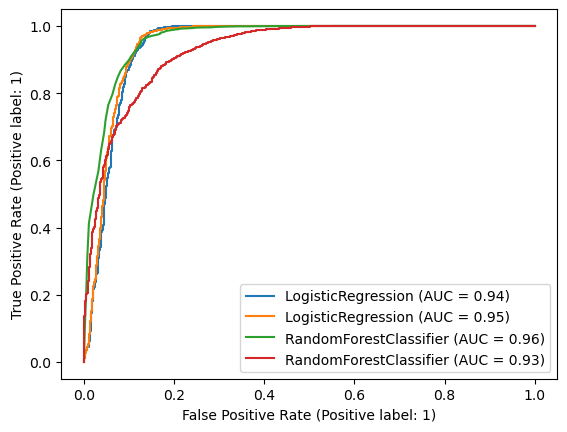

In [63]:
plot_roc_auc(models, X_test, y_test)

### D3.e. Model Building Conclusions

The accuracy score of the zero model is 0.85.
All models exhibits high scores in precision and recall. 

`The Logistic Regression classifier with weight balanced` scored highest at the two important metrics precision and recall:
- class 1 precision 0.98 
- class 0 recall at 0.87

## E. Feature Importance Analysis

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html

In [68]:
explainer = shap.KernelExplainer(log2.predict_proba, X_train)

2023-09-18 13:49:14,878:WARNING - Using 11944 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


**Explain a single prediction from the test set**

```
 shap_values = explainer.shap_values(X_test.iloc[0,:])
```

**Explain several prediction from the test set**

```
 shap_values = explainer.shap_values(X_test.head())
```

**Explain all the predictions in the test set**

```
 shap_values = explainer.shap_values(X_test)
```

In [70]:
explainer = shap.Explainer(log2, X_train)
shap_values = explainer(X_test)

## E1. Beeswarm Plot
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html


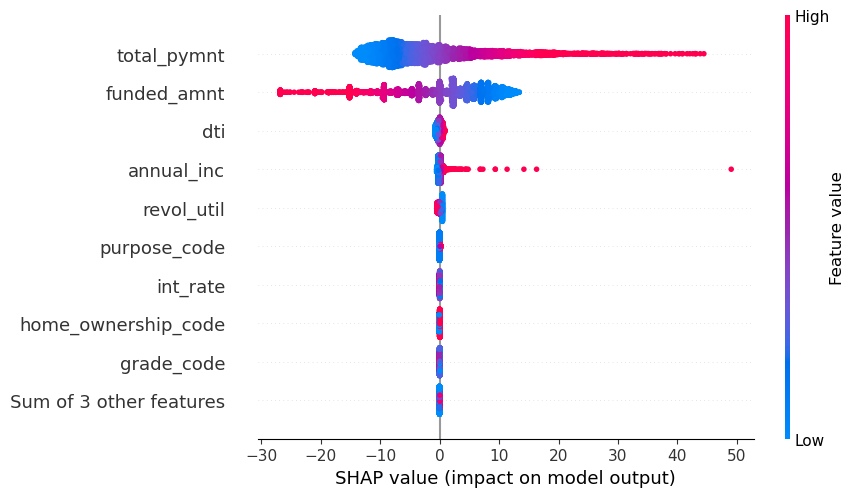

In [71]:
shap.plots.beeswarm(shap_values)

## E2. Partial Dependence Plot

In [75]:
from sklearn.inspection import PartialDependenceDisplay

In [85]:
X_test.head()

funded_amnt  loan_term_year  int_rate  grade_code  purpose_code  \
13202        15000               5     13.98           2             2   
3985         17625               5     10.59           1             2   
8230          7000               3      7.29           0             9   
6112          7000               3      5.99           0             2   
12496         2000               3     13.23           2             9   

       addr_state_code  home_ownership_code  annual_inc    dti  revol_util  \
13202                3                    0      125000  15.35        80.9   
3985                 5                    0       81000  11.19        42.2   
8230                 4                    0      150000  19.54        83.1   
6112                 5                    4       35000  10.80         2.9   
12496                2                    4       24702  15.06        97.2   

       pub_rec_bankruptcies   total_pymnt  
13202                   0.0  20932.049350  
3985                    0.0  22271.449980  
8230                    0.0   7622.612042  
6112                    0.0   7508.402271  
12496                   0.0   2434.304765

Fix the sizing
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html

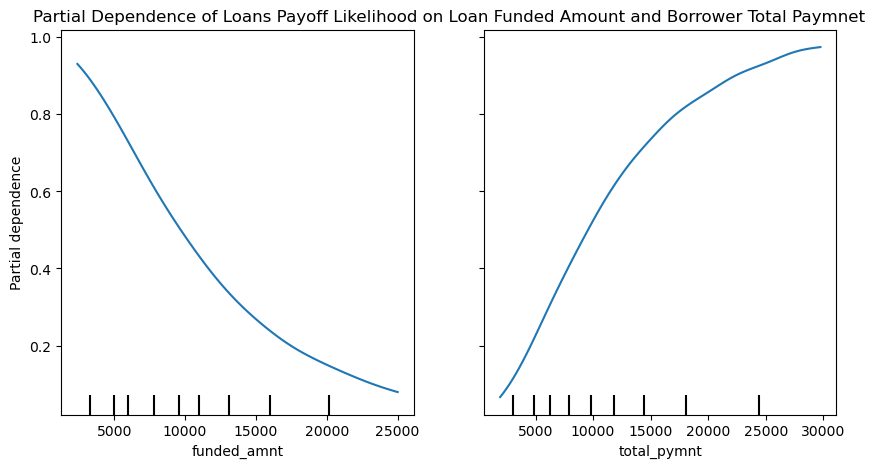

In [112]:
# Show the importance of 2 features 'funded_amnt' = index 0, and 'total_pymnt' = index 11
# features_index = [0, 11, (0,11)]
features_index = [0, 11]

# PartialDependenceDisplay.from_estimator(log2, X_test, features=features_index)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Partial Dependence of Loans Payoff Likelihood on Loan Funded Amount and Borrower Total Paymnet")
PartialDependenceDisplay.from_estimator(log2, X_test, features=features_index, ax=ax)

## E3. Summarize the effect of all the features

The most important features are:
- total payment: Payments received to date for total amount funded
- funded amount: The total amount committed to that loan at that point in time
- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations
- annual_inc: Borrower's annual income
- revol_util: Revolving line utilization rate

Loans that are more likely to be fully payoff when borrowers have:
- high amount of total payment up-to-date
- small asked loan amount
- high annual income

**Next step**

Train the model with the top 5 important features

---

# F. Construct Loan Portfolio

Construct a *loan portfolio* out of **the test set** with the help of your classification model. The portfolio can be a small subset of all loans in the dataset, for example, 50% of all loans in the test set.

- Predict on the test set with the trained model.
- Select loans that are predicted to be paid off by the model.
- Calculate annual return of selected loans.

We will demonstrate how to select portfolio with RandomForestClassifier. You will need to construct a portfolio with the Logistic Regression model.

### Portfolio Annual Return

Calculation of loan return is very complicated since the loan is paid by monthly installments. In this project, we simplify the calculation by using the total payment and funded amount. We can use following formula to calculate the total return:

$TotalReturn = \frac{Total Payment}{Funded Amount} - 1$

The total return doesn't reflect loan profitability since loans have different terms. It's more accurate to compare annual returns. There are only two terms in the dataset, 36 months and 60 months. The formula to calculate annual return is:

$Annualized Return = (1+Total Return)^{(1/years)} - 1$. 

For example, if total return of a 36 month loan is 10%, then annualized return = `(1 + 0.1)**(1/3) - 1` = `0.032`.

Again, this is not the true annualized return of a loan. But **the goal** of this project is to **identify loans to invest**, so we just need a benchmark to **evaluate loan portfolio performance**.

In the following code cells, we define a function to calculate annual return of a loan portfolio. The function calculates annual return for 36 month and 60 month loans in a portfolio separately. 

Then we use the `get_portfolio_annual_return()` function to find out the annual returns of all 36 months and 60 months loans in the test dataset. There are 5960 36 months loans, with annual return 2.69%, and 2004 60 months loans, with annual return 2.74%.

**Please make sure all above code cells are executed before moving on.**

In [113]:
def get_portfolio_annual_return(df):
    '''
    Get annual return of 36 and 60 month loans in the portfolio df.
    '''
    
    annual_return_36, annual_return_60 = 0, 0
    df_36 = df[df.loan_term_year==3]
    if(len(df_36)>0):
        return_36 = df_36.total_pymnt.sum()/df_36.funded_amnt.sum()-1
        annual_return_36 = (1+return_36)**(1/3)-1
    df_60 = df[df.loan_term_year==5]
    if(len(df_60)>0):
        return_60 = df_60.total_pymnt.sum()/df_60.funded_amnt.sum()-1
        annual_return_60 = (1+return_60)**(1/5)-1
    print (f'36 months loan:{len(df_36)}, Annual return:{round(annual_return_36, 4)}')
    print (f'60 months loan:{len(df_60)}, Annual return:{round(annual_return_60, 4)}')

In [114]:
#get current annual return of the test set
get_portfolio_annual_return(X_test)

36 months loan:5960, Annual return:0.0269
60 months loan:2004, Annual return:0.0274


### Construct Loan Portfolio with Logistic Regerssion

We will use the Logistic Regression model with `class_weight='balanced'` (log2) to select loans from the test set. Then we will compare the annual return of *the selected loans* with that of *the test set*. 

In [115]:
log2 = LogisticRegression(class_weight='balanced', random_state=23)
log2 = log2.fit(X_train, y_train)
pred = log2.predict(X_test)

# create prediction column in the test set.
df_test['prediction'] = pred

# select loans with a predicted labe "1" : predicted paidoff
portfolio_1s = df_test[df_test.prediction==1]

In [116]:
df_test.head()

funded_amnt  loan_term_year  int_rate  grade_code  purpose_code  \
13202        15000               5     13.98           2             2   
3985         17625               5     10.59           1             2   
8230          7000               3      7.29           0             9   
6112          7000               3      5.99           0             2   
12496         2000               3     13.23           2             9   

       addr_state_code  home_ownership_code  annual_inc    dti  revol_util  \
13202                3                    0      125000  15.35        80.9   
3985                 5                    0       81000  11.19        42.2   
8230                 4                    0      150000  19.54        83.1   
6112                 5                    4       35000  10.80         2.9   
12496                2                    4       24702  15.06        97.2   

       pub_rec_bankruptcies   total_pymnt  repaid  prediction  
13202                   0.0  20932.049350       1           1  
3985                    0.0  22271.449980       1           1  
8230                    0.0   7622.612042       1           1  
6112                    0.0   7508.402271       1           1  
12496                   0.0   2434.304765       1           1

In [117]:
# From the test test
get_portfolio_annual_return(df_test)

36 months loan:5960, Annual return:0.0269
60 months loan:2004, Annual return:0.0274


In [118]:
# From the selected loans that are predicted to be paidoff
get_portfolio_annual_return(portfolio_1s)

36 months loan:5180, Annual return:0.0509
60 months loan:1541, Annual return:0.0591


In [119]:
print("The number of loans that is predicted to be fully paid off :", len(portfolio_1s))

The number of loans that is predicted to be fully paid off : 6721


**Findings**

The RandomForestClassifier mode selects 
- 4223 loans from 5960 36 months loans, with annual return 2.95%
- 1278 loans from 2004 60 months loans, with annual return 3.06% 

The portfolio achieves better return on both 36 months loans and 60 months loans comparing to the whole test set, which are 2.69% and 2.74% respectively.


### Improvements with Filters

pub_rec_bankruptcies is the number of public record bankruptcies of a loan borrower. As show in the next code cell, vast majority of loans have pub_rec_bankruptcies = 0, which means no public record of bankruptcies.


In [120]:
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    19165
1.0      742
2.0        1
Name: count, dtype: int64

We may **include pub_rec_bankruptcies** in the training features. Another way is to use it **as a filter**. In the next code cell, we check returns of loans *with and without public record bankruptcies in the data set*.

On the *original dataset*:

In [121]:
#returns of loans without bankruptcy record
get_portfolio_annual_return(loan_df[loan_df.pub_rec_bankruptcies==0])

# notice this is on all the loans without bankruptcy, not selected "1" loans

36 months loan:14316, Annual return:0.029
60 months loan:4849, Annual return:0.029


In [122]:
#returns of loans with bankruptcy record
get_portfolio_annual_return(loan_df[loan_df.pub_rec_bankruptcies>0])

36 months loan:536, Annual return:0.0156
60 months loan:207, Annual return:0.0198


Since **loans without public bankruptcies recrods have significantly higher returns**, we *may filter out all loans that have public bankruptcies recrods* from the portfolio determined by log2. [The new portfolio has a little better return as shown in the following code cell.]

In [123]:
portfolio_1s.head()

funded_amnt  loan_term_year  int_rate  grade_code  purpose_code  \
13202        15000               5     13.98           2             2   
3985         17625               5     10.59           1             2   
8230          7000               3      7.29           0             9   
6112          7000               3      5.99           0             2   
12496         2000               3     13.23           2             9   

       addr_state_code  home_ownership_code  annual_inc    dti  revol_util  \
13202                3                    0      125000  15.35        80.9   
3985                 5                    0       81000  11.19        42.2   
8230                 4                    0      150000  19.54        83.1   
6112                 5                    4       35000  10.80         2.9   
12496                2                    4       24702  15.06        97.2   

       pub_rec_bankruptcies   total_pymnt  repaid  prediction  
13202                   0.0  20932.049350       1           1  
3985                    0.0  22271.449980       1           1  
8230                    0.0   7622.612042       1           1  
6112                    0.0   7508.402271       1           1  
12496                   0.0   2434.304765       1           1

In [124]:
portfolio_1s_no_prb = portfolio_1s[portfolio_1s.pub_rec_bankruptcies==0]
get_portfolio_annual_return(portfolio_1s_no_prb)

36 months loan:5004, Annual return:0.0507
60 months loan:1491, Annual return:0.059


### Impact of Loan Grade

Loan grade is assigned by Lending Club based on loan and borrower's information. Higher grade loans have higher repaid rate. On the other hand, higher grader loans also have lower interest rate. Portfolio return is determined by both repaid rate and interest rate. As shown in following code cells, a portfolio with all grade A loans actually have lower annual return for both 36 months loans and 60 months loans comparing to the whole dataset.

In [ ]:
get_portfolio_annual_return(df_test)

In [ ]:
#All grade A loans
get_portfolio_annual_return(df_test[df_test.grade_code==0])

---

# Appendices

## E2. Summary Plot

**Explain a single prediction from the test set**

In [ ]:
shap_values_0 = explainer.shap_values(X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values_0, X_test.iloc[0,:])

**5 values from the test set**

In [ ]:
shap_values = explainer.shap_values(X_test.head())

In [ ]:
shap.summary_plot(shap_values, X_test.head())

## E3. Force Plot

In [ ]:
explainer.expected_value

**Explain a single prediction from the test set**

In [ ]:
shap.initjs()
shap_values_0 = explainer.shap_values(X_test.iloc[0,:])

# Force Plot: label "0", for negative outcomes
shap.force_plot(explainer.expected_value[0], shap_values_0[0], X_test.iloc[0,:])

In [ ]:
# Force Plot: label "1", for positive outcomes
shap.force_plot(explainer.expected_value[1], shap_values_0[1], X_test.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values_0[1], X_test.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values_0[0], X_test.iloc[0,:])

**5 values from the test set**

In [ ]:
# Since the dataset is too large and memory cosumming, I will apply the SHAP on first 5 values only
# look at fully-paid loans with label “1” (expected_value[1])
# pull out SHAP values for positive outcomes (pulling out shap_values[1]).
shap.initjs()
# shap_values = explainer.shap_values(X_test.head())

shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.head())

In [ ]:
shap_values

In [ ]:
y_pred = log2.predict_proba(X_test)[:,1]
y_pred_label = log2.predict(X_test)

In [ ]:
y_test[:5]

In [ ]:
y_pred_label[:5]

In [ ]:
# shap.initjs()

# shap_values = explainer.shap_values(X_test.head())
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.head())